# Mixture
In this example we will use the data that was generated as follows:

1. 10 means $m_k$ were drawn from a bivariate Gaussian distribution $\mathcal{N}((1,0),I)$ and labeled *BLUE*. 
2. 10 more were drawn from $\mathcal{N}((0,1),I)$ and labeled *ORANGE*. 
3. For each class 100 observations were generated as follows: 
  1. $m_k$ was picked at random with probability 1/10;
  2. observation was drawn from $\mathcal{N}(m_k,I/5)$, thus leading to a mixture of Gaussian clusters for each class.
  
The task is to create a classifier that, based on the coordinates, determines whether the point is *ORANGE* or *BLUE*. Of course, the classifier should not be based on then knowledge of how the data was generated.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

# numpy produces many warnings, we don't need them here
np.warnings.filterwarnings('ignore')

# define commonly used colors
GRAY1, GRAY4, PURPLE = '#231F20', '#646369', '#A020F0'
BLUE, ORANGE, BLUE1 = '#57B5E8', '#E69E00', '#174A7E'

# configure all plots font family and border line widths
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5

## Load and Prepare Data
We have training samples that were used in the book. Also, the means for all *BLUE* and *ORANGE* clusters are known. Test samples are unknown, and we will generate them ourselves.

In [2]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.mixture.gaussian_mixture import _compute_precision_cholesky
import pandas as pd

In [3]:
# load training data that was used in the book
df = pd.read_csv("../data/mixture.txt")
X_train = df[['x1', 'x2']].values
y_train = df.y.values

# set the known BLUE and ORANGE clusters means
blue_means = np.array([[-0.25343316, 1.7414788], [0.26669318, 0.3712341],
                       [2.09646921, 1.2333642], [-0.06127272, -0.2086791],
                       [2.70354085, 0.5968283], [2.37721198, -1.1864147],
                       [1.05690759, -0.6838939], [0.57888354, -0.0683458],
                       [0.62425213, 0.5987384], [1.67335495, -0.2893159]])
orange_means = np.array([[1.19936869, 0.2484086], [-0.30256110, 0.9454190],
                         [0.05727232, 2.4197271], [1.32932203, 0.8192260],
                         [-0.07938424, 1.6138017], [3.50792673, 1.0529863],
                         [1.61392290, 0.6717378], [1.00753570, 1.3683071],
                         [-0.45462141, 1.0860697], [-1.79801805, 1.9297806]])
all_means = np.vstack((blue_means, orange_means))

In [4]:
# even though we already know means and covariances, we need to
# do "fake fit", otherwise GaussianMixture model will not work
gaussian_mixture_model = GaussianMixture(
    n_components=20,
    covariance_type='spherical',
    means_init=all_means,
    random_state=1
).fit(all_means)
# set known covariances
gaussian_mixture_model.covariances_ = [1/5]*20
# it looks like a hack, but GaussianMixture uses precisions_cholesky_
# for predict_proba method. Because we changed covariances_ we need
# to recalculate precisions_cholesky_ too.
gaussian_mixture_model.precisions_cholesky_ = _compute_precision_cholesky(
    gaussian_mixture_model.covariances_,
    gaussian_mixture_model.covariance_type)

In [5]:
# sample 10,000 points for testing
X_test, y_test = gaussian_mixture_model.sample(10000)
# y_test contains sampled component indices
# index < 10 means that the class is BLUE (0)
y_test = 1*(y_test >= 10)

## Optimal Bayes
Since we know the distribution from which our data was sampled, we can build the optimal Bayes classifier and calculate the optimal Bayes test error rate. Let's write a classification function that takes samples as an input and produces a vector of predicted classes.

In [6]:
def optimal_bayes_predict(X):
    components_proba = gaussian_mixture_model.predict_proba(X)
    # first 10 components are BLUE(0), and others are BROWN(1)
    blue_proba = np.sum(components_proba[:, :10], axis=1)
    brown_proba = np.sum(components_proba[:, 10:], axis=1)
    y_hat = 1*(blue_proba < brown_proba)
    return y_hat

In [7]:
bayes_error_rate = 1 - accuracy_score(y_test, optimal_bayes_predict(X_test))
print(f'The optimal Bayes error rate = {bayes_error_rate}')

The optimal Bayes error rate = 0.2148


## Prepare Plotting Functions
We are going to draw many plots. But all the plots are similar to each other. The features we need to show are:
1. *BLUE* and *ORANGE* circles representing training data.
2. Small background *BLUE* and *ORANGE* dots along with the model decision boundary.
3. The optimal Bayes decision boundary.
4. Information about model's training and test error rates.

Let's implement plotting functions. The main input for the plotting function is a model prediction function that takes a matrix **X** and produces a vector **y** of predicted classes (0 or 1).

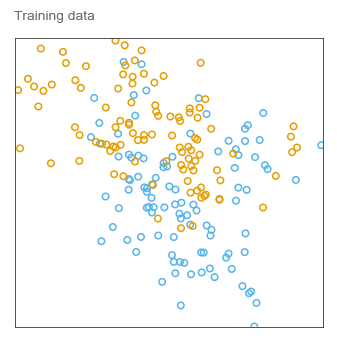

In [8]:
# prepares a plot with a title and circles representing training data
def plot_train_data(title):
    fig, ax = plt.subplots(figsize=(2.8, 2.8), dpi=110)
    ax.set_aspect(1.3)
    ax.scatter(X_train[:, 0], X_train[:, 1], s=18, facecolors='none',
               edgecolors=np.array([BLUE, ORANGE])[y_train])
    ax.tick_params(
        bottom=False, left=False, labelleft=False, labelbottom=False)
    ax.set_xlim(-2.6, 4.2)
    ax.set_ylim(-2.0, 2.9)
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    ax.text(-2.6, 3.2, title, color=GRAY4, fontsize=9)
    for spine in ax.spines.values():
        spine.set_color(GRAY1)
    return fig, ax

# test it
_, _ = plot_train_data('Training data')

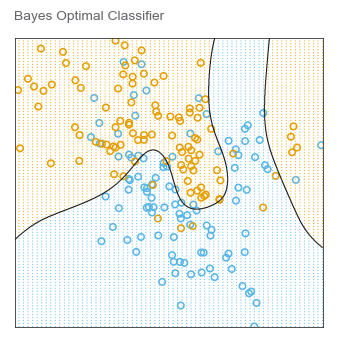

In [9]:
# given a model prediction function computes X points on n x n grid and the
# corresponding predicted classes
def fill_prediction_grid(n1, n2, predict):
    x1, x2 = np.linspace(-2.6, 4.2, n1), np.linspace(-2.0, 2.9, n2)
    X = np.transpose([np.tile(x1, n2), np.repeat(x2, n1)])
    y = predict(X)
    return X, y


# given a model prediction function computes X0 and X1 n x n meshgrids
# and the corresponing predicted classes meshgrid
def fill_prediction_meshgrid(predict):
    n1, n2 = 1000, 1000
    X, y = fill_prediction_grid(n1, n2, predict)
    return X[:, 0].reshape(n1, n2), X[:, 1].reshape(n1, n2), y.reshape(n1, n2)


# given a model prediction function plots train data, model decision
# bounary and background dots
def plot_model(predict, title):
    fig, ax = plot_train_data(title)
    # plot background dots
    X, y = fill_prediction_grid(69, 99, predict)
    ax.scatter(X[:, 0], X[:, 1], marker='.', lw=0, s=2,
               c=np.array([BLUE, ORANGE])[y])
    # plot the decision boundary
    X0, X1, Y = fill_prediction_meshgrid(predict)
    ax.contour(X0, X1, Y, [0.5], colors=GRAY1, linewidths=[0.7])
    return fig, ax

# plot the optimal Bayes decision boundary
_, _ = plot_model(optimal_bayes_predict, 'Bayes Optimal Classifier')

In [10]:
# lets save Bayes meshgrids for optimal decision boundary plotting
X0_bayes, X1_bayes, Y_bayes = fill_prediction_meshgrid(optimal_bayes_predict)


# given a model prediction function plots performance statistics
def plot_model_stat(predict, title):
    fig, ax = plot_model(predict, title)
    ax.contour(X0_bayes, X1_bayes, Y_bayes, [0.5], colors='purple',
               linewidths=[0.5], linestyles='dashed')
    test_error_rate = 1 - accuracy_score(y_test, predict(X_test))
    train_error_rate = 1 - accuracy_score(y_train, predict(X_train))
    parms = {'color': GRAY1, 'fontsize': 7,
             'bbox': {'facecolor': 'white', 'pad': 3, 'edgecolor': 'none'}}
    ax.text(-2.42, -1.35, f'Training Error: {train_error_rate:.3f}', **parms)
    ax.text(-2.42, -1.62, f'Test Error:       {test_error_rate:.3f}', **parms)
    ax.text(-2.42, -1.89, f'Bayes Error:    {bayes_error_rate:.3f}', **parms)
    return fig, ax

<h2>Linear Regression</h2>

In [11]:
from sklearn.linear_model import LinearRegression

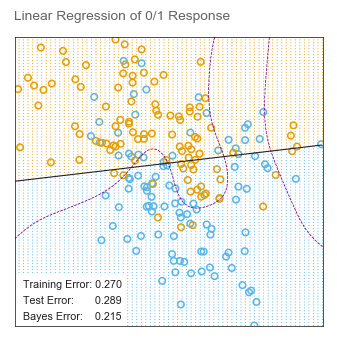

In [12]:
# PAGE 12. Let’s look at an example of the linear model in a classiﬁcation
#          context.
linear_regression_model = LinearRegression().fit(X_train, y_train)


# PAGE 12. The fitted values Y-hat are converted to a fitted class variable
#          G-hat according to the rule G-hat = (ORANGE if Y-hat > 0.5, BLUE if
#          Y-hat ≤ 0.5.
def linear_predict(X):
    return 1*(linear_regression_model.predict(X) > 0.5)

# PAGE 13. The line is the decision boundary deﬁned by x.T @ b = 0.5. The
#          orange shaded region denotes that part of input space classiﬁed as
#          ORANGE, while the blue region is classiﬁed as BLUE.
_, _ = plot_model_stat(linear_predict, 'Linear Regression of 0/1 Response')

<h2>Nearest-Neighbor Methods</h2>

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [14]:
# Run GridSearchCV to find the best n_neighbors parameter using the 10-folds
# CV. It finds 12, but the book uses 15-Nearest Neighbor Classifier because
# the authors selected the most parsimonious model within one standard error
# from the best model (one standard error rule). We will apply this rule in
# other examples, not here.
k_neighbors_grid_search = GridSearchCV(
    KNeighborsClassifier(),
    {'n_neighbors': list(range(1, 50))},
    cv=10
).fit(X_train, y_train)
k_neighbors_grid_search.best_params_

{'n_neighbors': 12}

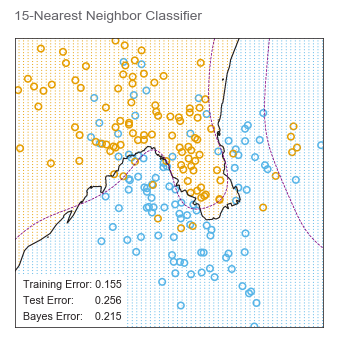

In [15]:
# PAGE 14. Use 15-nearest-neighbor averaging of the binary coded response as
#          the method of fitting. Thus Y-hat is the proportion of ORANGE’s in
#          the neighborhood, and so assigning class ORANGE to G-hat if
#          Y-hat>0.5 amounts to a majority vote in the neighborhood.
neighbors15_classifier = KNeighborsClassifier(
    n_neighbors=15
).fit(X_train, y_train)
_, _ = plot_model_stat(
    neighbors15_classifier.predict, '15-Nearest Neighbor Classifier')

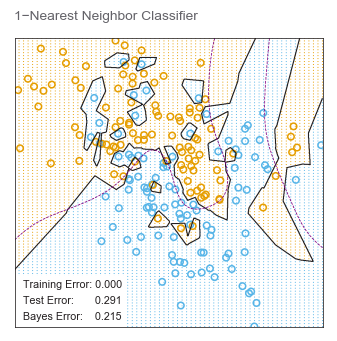

In [16]:
# PAGE 16. The classes are coded as a binary variable (BLUE = 0,ORANGE = 1),
#          and then predicted by 1-nearest-neighbor classiﬁcation.
neighbors1_classifier = KNeighborsClassifier(
    n_neighbors=1
).fit(X_train, y_train)
_, _ = plot_model_stat(
    neighbors1_classifier.predict, '1−Nearest Neighbor Classifier')

## Logistic Regression over Natural Cubic Splines
I did not find a Python library for natural cubic spline basis expansion and implemented it myself. The class has fit/transform methods and so can be used in pipelines. The formula for the expansion is given on the page 145 (5.4).

$N_{1}(X)=1, N_{2}(X)=X, N_{k+2}(X)=d_{k}(X)-d_{K-1}(X)$,

where $d_{k}(X)=\frac{(X-\xi_{k})_{+}^{3}-(X-\xi_{K})_{+}^{3}}{\xi_{K}-\xi_{k}}$

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
import itertools
from typing import List

In [18]:
class NaturalCubicSplineFeatures(BaseEstimator, TransformerMixin):
    """Generate natural cubic spline and interaction features.
    Parameters
    ----------
    knots :
        Is a list that contains knots list for each feature.
    add_interactions :
        If false, only natural cubic spline features are produced, otherwise
        expanded features interactions are included.
    target_dofs :
        Is a number of degrees of freedom for each feature. If is set, df+1
        knots for features would be automatically calculated at uniform
        quantiles including min and max value of a feature.
    Attributes
    ----------
    dofs_:
        The degrees of freedom for each feature.
    positions_:
        For each feature the index of the first and the last indices of its
        components."""
    def __init__(self, knots: List[List[float]]=None, target_dofs: int=None,
                 add_interactions: bool = False):
        self.knots = knots
        self.add_interactions = add_interactions
        self.target_dofs = target_dofs

    def fit(self, X: np.ndarray,
            y: np.array=None) -> 'NaturalCubicSplineFeatures':
        """Fit NaturalCubicSplineFeatures model according to the given training
           data and parameters.
        Parameters
        ----------
        X :
            Training data.
        y :
            Target values.
        """
        if self.target_dofs is not None:
            quantiles = np.linspace(0, 1, self.target_dofs + 1)
            self.knots = []
            for i in range(X.shape[1]):
                self.knots.append(np.unique(np.quantile(X[:, i], quantiles)))
        # calculate the number of parameters in each component term
        self.dofs_ = np.array([len(k)-1 for k in self.knots])
        # for each feature calculate the first and the last index of expanded
        # basis
        dofs_cumsum = [0] + list(np.cumsum(self.dofs_))
        self.positions_ = [(dofs_cumsum[i-1], dofs_cumsum[i]-1)
                           for i in range(1, len(dofs_cumsum))]
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        """Transform data to natural cubic spline basis expansion
        Parameters
        ----------
        X :
            The data to transform, row by row
        Returns
        -------
        X_new : np.ndarray, shape [n_samples, NN]
            The matrix of features, where NN is the number of natural cubic
            spline features generated from the inputs based on knots.
        """
        features_basis_splines = []
        for i in range(X.shape[1]):
            features_basis_splines.append(
                self.__expand_natural_cubic(X[:, i:i+1], self.knots[i]))
        if self.add_interactions:
            self.__add_interaction_features(features_basis_splines)
        return np.hstack(features_basis_splines)

    @staticmethod
    def __dk(X: np.ndarray, knot: float, knot_last: float) -> np.ndarray:
        return (X - knot).clip(0) ** 3 / (knot_last - knot)

    @staticmethod
    def __expand_natural_cubic(X: np.ndarray, knots: np.array) -> np.ndarray:
        basis_splines = [X]
        dk_last = NaturalCubicSplineFeatures.__dk(X, knots[-2], knots[-1])
        for knot in knots[:-2]:
            dk = NaturalCubicSplineFeatures.__dk(X, knot, knots[-1])
            basis_splines.append(dk - dk_last)
        return np.hstack(basis_splines)

    @staticmethod
    def __add_interaction_features(features_basis_splines):
        features_indices = [list(range(expansion.shape[1]))
                            for expansion in features_basis_splines]
        for combination in itertools.product(*features_indices):
            product = features_basis_splines[0][:, combination[0]].copy()
            for i in range(1, len(combination)):
                product *= features_basis_splines[i][:, combination[i]]
            features_basis_splines.append(np.atleast_2d(product).T)

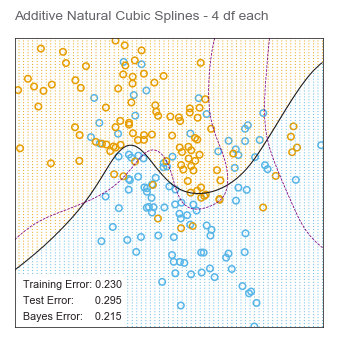

In [19]:
# knots for natrual cubic splines
knots = np.array([-2, 0, 1, 3])
# PAGE 164. The upper panel shows the decision boundary of an additive logistic
#           regression model, using natural splines in each of the two
#           coordinates (total df = 1 + (4−1) + (4−1) = 7).
splines_logreg = Pipeline(
    [('expand', NaturalCubicSplineFeatures([knots, knots])),
     ('scale', StandardScaler()),
     ('logistic', LogisticRegression(C=1000, solver='lbfgs'))]
).fit(X_train, y_train)
_, _ = plot_model_stat(
    splines_logreg.predict, 'Additive Natural Cubic Splines - 4 df each')

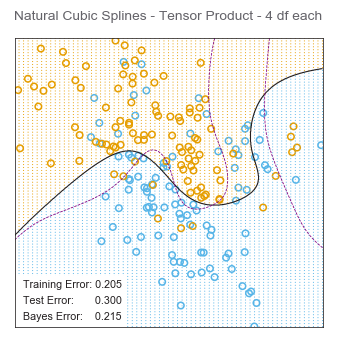

In [20]:
# PAGE 164. The lower panel shows the results of using a tensor product of
#           natural spline bases in each coordinate (total df = 4 × 4 = 16).
splines_product_logreg = Pipeline([
    ('exp', NaturalCubicSplineFeatures(
        knots=[knots, knots], add_interactions=True)),
    ('scale', StandardScaler()),
    ('logistic', LogisticRegression(C=10000, solver='lbfgs'))]
).fit(X_train, y_train)
_, _ = plot_model_stat(
    splines_product_logreg.predict,
    'Natural Cubic Splines - Tensor Product - 4 df each')

<h2>Neural Networks</h2>

In [21]:
import tensorflow as tf
import math
from sklearn.preprocessing import OneHotEncoder

In [22]:
# PAGE 398. Since the scaling of the inputs determines the effective scaling of
#           the weights in the bottom layer, it can have a large effect on the
#           quality of the final solution. At the outset it is best to
#           standardize all inputs to have mean zero and standard deviation
#           one. This ensures all inputs are treated equally in the
#           regularization process, and allows one to choose a meaningful range
#           for the random starting weights.
scaler = StandardScaler().fit(X_train)
X_train_standartized = scaler.transform(X_train)

# PAGE 392. For K-class classiﬁcation, there are K units at the top, with the
#           k-th unit modeling the probability of class k. There are K target
#           measurements Yk, k = 1,...,K, each being coded as a 0−1 variable
#           for the kth class.
Y_train_one_hot = OneHotEncoder(
    categories='auto'
).fit_transform(np.atleast_2d(y_train).T).toarray()

In [23]:
session = tf.Session()

In [24]:
n_hidden = 10
initializer = tf.contrib.layers.xavier_initializer(seed=1)

x = tf.placeholder(tf.float64, shape=[None, 2])
y = tf.placeholder(tf.float64, shape=[None, 2])

A = tf.Variable(initializer([2, n_hidden], dtype=tf.float64))
a0 = tf.Variable(initializer([1, n_hidden], dtype=tf.float64))
B = tf.Variable(initializer([n_hidden, 2], dtype=tf.float64))
b0 = tf.Variable(initializer([2], dtype=tf.float64))

# PAGE 392. Derived features Zm are created from linear combinations of the
#           inputs, and then the target Yk is modeled as a function of linear
#           combinations of the Zm, The activation function σ(v) is usually
#           chosen to be the sigmoid σ(v) = 1/(1+e^−v);
Z = tf.nn.sigmoid(a0 + x@A)
T = b0 + Z@B

# PAGE 393. The output function gk(T) allows a final transformation of the
#           vector of outputs T. For regression we typically choose the
#           identity function gk(T) = Tk. Early work in K-class classiﬁcation
#           also used the identity function, but this was later abandoned in
#           favor of the softmax function
y_hat = tf.nn.softmax(T)

# PAGE 395. For classiﬁcation we use either squared error or cross-entropy
#           (deviance)
cross_entropy = y*tf.log(y_hat)
loss = tf.reduce_mean(-tf.reduce_sum(cross_entropy, reduction_indices=1))

In [25]:
feed_dict = {x: X_train_standartized, y: Y_train_one_hot}

In [26]:
# PAGE 395. The generic approach to minimizing R(θ) is by gradient descent,
#           called back-propagation in this setting. Because of the
#           compositional form of the model, the gradient can be easily derived
#           using the chain rule for differentiation. This can be computed by a
#           forward and backward sweep over the network, keeping track only of
#           quantities local to each unit.
adm = tf.train.AdamOptimizer(1e-2).minimize(loss)

# PAGE 395. Typically we don’t want the global minimizer of R(θ), as this is
#           likely to be an overfit solution. Instead some regularization is
#           needed: this is achieved directly through a penalty term, or
#           indirectly by early stopping.
admW = tf.contrib.opt.AdamWOptimizer(0.0028, learning_rate=1e-2).minimize(loss)

In [27]:
# let's write a generic training procedure
def train_and_plot(optimizer_step, title):
    session.run(tf.global_variables_initializer())
    step = 0
    # calc initial loss
    current_loss = session.run(loss, feed_dict)
    while step < 20000:
        step += 1
        if math.log(step, 5).is_integer():
            print(f'step: {step}, current loss: {current_loss}')
        session.run(optimizer_step, feed_dict)
        current_loss = session.run(loss, feed_dict)
    print(f'ENDED ON STEP: {step}, FINAL LOSS: {current_loss}')

    def nn_predict(X):
        X = scaler.transform(X)
        # PAGE 395. and the corresponding classiﬁer is G(x) = argmax kfk(x)
        return np.argmax(session.run(y_hat, {x: X}), axis=1)

    plot_model_stat(nn_predict, title)

step: 1, current loss: 0.8709270406577173
step: 5, current loss: 0.73879669152708
step: 25, current loss: 0.6051715552948866
step: 625, current loss: 0.48102861245398204
step: 3125, current loss: 0.3161895310120571
ENDED ON STEP: 20000, FINAL LOSS: 0.2460552775000382
step: 1, current loss: 0.7087873115952749
step: 5, current loss: 0.6879177042808666
step: 25, current loss: 0.6115054073129821
step: 625, current loss: 0.44875345389818366
step: 3125, current loss: 0.4153904731630477
ENDED ON STEP: 20000, FINAL LOSS: 0.37550112870573615


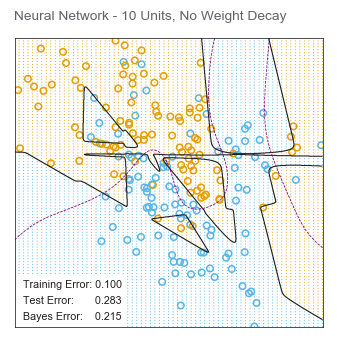

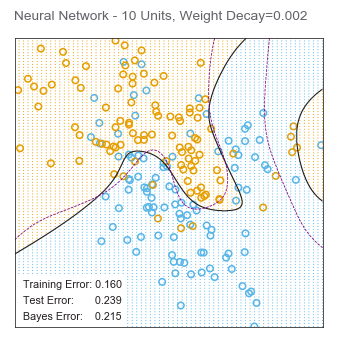

In [28]:
# PAGE 399. A neural network on the mixture example of Chapter 2. The upper
#           panel uses no weight decay, and overfits the training data. The
#           lower panel uses weight decay, and achieves close to the Bayes
#           error rate (broken purple boundary). Both use the softmax
#           activation function and cross-entropy error.
train_and_plot(adm, 'Neural Network - 10 Units, No Weight Decay')
train_and_plot(admW, 'Neural Network - 10 Units, Weight Decay=0.002')

## Support Vector Machines

In [29]:
from sklearn.svm import SVC

In [30]:
# plots support vector machine model information, margins and
# small black points for observations that lay on the margin.
def plot_svc_model(svc, title):
    sv = abs(svc.decision_function(svc.support_vectors_))
    v = svc.support_vectors_[(sv > 0.99) & (sv < 1.01)]
    fig, ax = plot_model_stat(svc.predict, title)
    X0, X1, Y = fill_prediction_meshgrid(svc.decision_function)
    ax.contour(X0, X1, Y, [-1, 1], colors=GRAY1, linewidths=[0.5, 0.5],
               linestyles='dashed')
    ax.scatter(v[:, 0], v[:, 1], c='black', s=10)

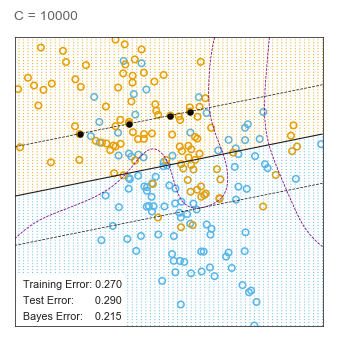

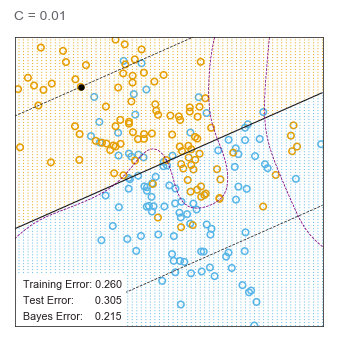

In [31]:
# PAGE 422. The linear support vector boundary for the mixture data example
#           with two overlapping classes, for two different values of C.
#           The broken lines indicate the margins, where f(x) = ±1. The support
#           points (αi > 0) are all the points on the wrong side of their
#           margin.
linear_svc1 = SVC(
    C=10000, kernel='linear'
).fit(X_train, y_train)
plot_svc_model(linear_svc1, 'C = 10000')

# PAGE 422. In the upper panel 62% of the observations are support points,
#           while in the lower panel 85% are.
linear_svc2 = SVC(
    C=0.01, kernel='linear'
).fit(X_train, y_train)

# PAGE 421.  The margin is larger for C = 0.01 than it is for C = 10,000. Hence
#            larger values of C focus attention more on (correctly classiﬁed)
#            points near the decision boundary, while smaller values involve
#            data further away. Either way, misclassified points are given
#            weight, no matter how far away. In this example the procedure is
#            not very sensitive to choices of C, because of the rigidity of a
#            linear boundary.
plot_svc_model(linear_svc2, 'C = 0.01')

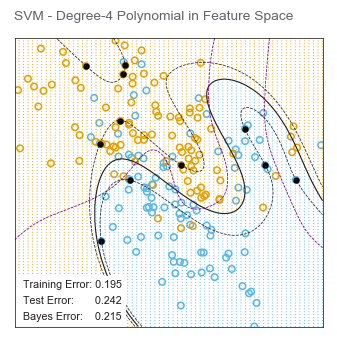

In [32]:
poly_svc = SVC(
    kernel='poly', degree=4, coef0=7, C=10
).fit(X_train, y_train)
plot_svc_model(poly_svc, 'SVM - Degree-4 Polynomial in Feature Space')

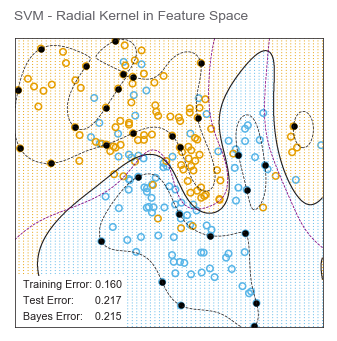

In [33]:
rbf_svc = SVC(
    kernel='rbf', gamma=1
).fit(X_train, y_train)
plot_svc_model(rbf_svc, 'SVM - Radial Kernel in Feature Space')

## FDA/MARS & MDA
I have not found the flexible discriminant analysis implementation for Python and implemented it myself. The result is close to the result from the book, but slightly worse. Maybe I made some mistakes. More research and testing is needed. The approch is explained here https://www.researchgate.net/publication/2889611_Flexible_Discriminant_Analysis_by_Optimal_Scoring.

In [34]:
from scipy.stats import multivariate_normal
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import LabelEncoder
from pyearth import Earth

In [35]:
class FlexibleDiscriminantAnalysis(BaseEstimator, TransformerMixin):
    """Flexible Discriminant Analysis
    A classifier with nonlinear decision boundary, based on adaptive
    multivariate regression and optimal scoring approach.
    Parameters
    ----------
    model :
        Multivariate nonparameteric regression. Should have fit method,
        transform method (for basis expansion).
    n_components :
        Number of components for dimensionality reduction.
    """
    def __init__(self, model, n_components: int = None):
        self.model = model
        self.n_components = n_components

    def fit(self,
            X: np.ndarray,
            y: np.array) -> 'FlexibleDiscriminantAnalysis':
        """Fit FlexibleDiscriminantAnalysis model according to the given
           training data and parameters.
        Parameters
        ----------
        X :
            Training data.
        y :
            Target values.
        """
        # relabel target values to start from zero
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)
        self.classes_ = label_encoder.classes_
        _, counts_elements = np.unique(y, return_counts=True)
        # PAGE 440. We create an N × K indicator response matrix Y
        Y = OneHotEncoder(
            categories='auto'
        ).fit_transform(np.atleast_2d(y).T).toarray()

        # PAGE 441. Multivariate nonparametric regression. Fit a multiresponse,
        #           adaptive nonparametric regression of Y on X
        self.model.fit(X, Y)
        X_exp = self.model.transform(X)
        lr = LinearRegression(fit_intercept=False).fit(X_exp, Y)
        Y_hat = lr.predict(X_exp)

        # PAGE 441. Optimal scores. Compute the eigen-decomposition of
        #           Y.T @ Y_hat
        evals, evecs = np.linalg.eig(Y.T @ Y_hat)
        evals_ord = np.argsort(evals)[::-1]
        evals = evals[evals_ord]
        evecs = evecs[:, evals_ord]
        priors = Y.T @ Y / len(y)
        evecs = evecs / np.sqrt(np.diag(priors))

        # PAGE 441. Update the model from step 1 using the optimal scores.
        self.coef_ = evecs.T @ lr.coef_
        R = self.transform(X)
        self.lda_ = LinearDiscriminantAnalysis().fit(R, y)
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        """Project data to maximize class separation.
        Parameters
        ----------
        X :
            Input data.
        Returns
        -------
        X_new :
            Transformed data.
        """
        X_exp = self.model.transform(X)
        R = X_exp @ self.coef_.T
        if self.n_components is None:
            return R
        return R[:, :self.n_components]

    def predict(self, X: np.ndarray) -> np.array:
        X_new = self.transform(X)
        return self.classes_[self.lda_.predict(X_new)]

In [36]:
fda = FlexibleDiscriminantAnalysis(
    Earth(max_terms=19, max_degree=2, enable_pruning=False)
).fit(X_train, y_train)

In [37]:
class MixtureDiscriminantAnalysis(BaseEstimator, TransformerMixin):
    """Mixture Discriminant Analysis
    A classifier with nonlinear decision boundary, where each class is
    represented by a mixture of components.
    Parameters
    ----------
    n_prototypes :
        Number of prototypes for each class.
    max_iter :
        Maximum number of iterations of the EM algorithm for a single run.
    random_state :
        Determines random number generation for centroid initialization.
    """
    def __init__(self, n_prototypes: int, max_iter: int=100,
                 random_state: int=0):
        self.n_prototypes = n_prototypes
        self.random_state = random_state
        self.max_iter = max_iter

    def fit(self,
            X: np.ndarray,
            y: np.array) -> 'MixtureDiscriminantAnalysis':
        """Fit MixtureDiscriminantAnalysis model according to the given
           training data and parameters.
        Parameters
        ----------
        X :
            Training data.
        y :
            Target values.
        """
        # relabel target values to start from zero
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)
        self.classes_ = label_encoder.classes_
        N, p, K = *X.shape, self.classes_.size
        _, counts = np.unique(y, return_counts=True)
        self.priors_ = counts / len(y)
        # set initial random means for prototypes at random quantiles
        np.random.seed(self.random_state)
        means = np.stack(
            [np.vstack([np.quantile(
                X[y == k][:, i], np.random.uniform(0, 1, self.n_prototypes))
                for i in range(p)]).T
             for k in range(K)])
        # assign each observation to the closest class prototype
        # and calculate mixin proportions
        obs_protos = np.zeros(shape=N, dtype=int)
        for i in range(N):
            obs_protos[i] = np.argmin(np.sum((means[y[i]] - X[i])**2, axis=1))
        mixin_props = np.stack(
            [np.bincount(obs_protos[y == k]) / np.sum(y == k)
             for k in range(K)])
        # calculate init covariance matrix based on hard prototype assignment
        cov = np.zeros(shape=(p, p))
        for k in range(K):
            for r in range(self.n_prototypes):
                Xkr = X[(y == k) & (obs_protos == r), :]
                cov += mixin_props[k, r] * \
                       self.priors_[k] * np.cov(Xkr.T, bias=True)

        # do Expectation-Maximization
        for step in range(self.max_iter):
            # calculate responsibility for each observation
            resps = self.__e_step(N, X, cov, means, mixin_props, y)
            # calculate means, cov-matrix and mixin proportions
            cov, means, mixin_props = self.__m_step(N, X, p, resps, y)

        self.means_ = means
        self.mixin_props_ = mixin_props
        self.cov_ = cov
        return self

    def __m_step(self, N, X, p, resps, y):
        # PAGE 450. M-step: Compute the weighted MLEs for the parameters of
        #           each of the component Gaussians within each of the
        #           classes, using the weights from the E-step.
        K = self.classes_.size
        means = np.zeros(shape=(K, self.n_prototypes, p))
        cov = np.zeros(shape=(p, p))
        mixin_props = np.zeros(shape=(K, self.n_prototypes))
        for k in range(K):
            Xk, class_resp = X[y == k], resps[y == k]
            for r in range(self.n_prototypes):
                proto_resp = class_resp[:, r:r+1]
                mixin_props[k, r] = np.sum(proto_resp) / Xk.shape[0]
                means[k, r] = np.sum(Xk*proto_resp, axis=0)/np.sum(proto_resp)
        for i in range(N):
            for r in range(self.n_prototypes):
                v = np.atleast_2d(X[i] - means[y[i], r]).T
                cov += resps[i, r] * (v @ v.T)
        cov /= N
        return cov, means, mixin_props

    def __e_step(self, N, X, cov, means, mixin_proportions, y):
        # PAGE 450. E-step: Given the current parameters, compute the
        #           responsibility of subclass ckr within class k for each
        #           of the class-k observations (gi = k): (12.62)
        resps = np.zeros((N, self.n_prototypes))
        for i in range(N):
            k = y[i]
            for r in range(self.n_prototypes):
                prob = multivariate_normal.pdf(X[i], means[k, r], cov)
                resps[i, r] = mixin_proportions[k, r] * prob
            resps[i] /= np.sum(resps[i])
        return resps

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        # PAGE 449. Given such a model for each class, the class
        #           posterior probabilities are given by (12.60)
        K = self.classes_.size
        proto_proba = np.zeros((X.shape[0], K, self.n_prototypes))
        for k in range(K):
            for r in range(self.n_prototypes):
                prob = self.mixin_props_[k, r] * multivariate_normal.pdf(
                    X, self.means_[k, r], self.cov_) * self.priors_[k]
                proto_proba[:, k, r] = prob

        proba = np.sum(proto_proba, axis=2)
        denominators = np.sum(proba, axis=1)
        proba /= denominators[:, None]
        return proba

    def predict(self, X: np.ndarray) -> np.array:
        result = self.classes_[np.argmax(self.predict_proba(X), axis=1)]
        return result

In [38]:
# PAGE 449. Linear discriminant analysis can be viewed as a prototype
#           classifier. Each class is represented by its centroid, and we
#           classify to the closest using an appropriate metric. In many
#           situations a single prototype is not sufficient to represent
#           inhomogeneous classes, and mixture models are more appropriate.
mda = MixtureDiscriminantAnalysis(5, 100, 30).fit(X_train, y_train)

In [39]:
# draws model detailed plot and adds blue and orange prototypes to it
def plot_prototypes_model(predict, title, blue_prototypes, orange_prototypes):
    fig, ax = plot_model_stat(predict, title)
    ax.scatter(blue_prototypes[:, 0], blue_prototypes[:, 1],
               s=50, facecolors=BLUE, edgecolors='black')
    ax.scatter(orange_prototypes[:, 0], orange_prototypes[:, 1],
               s=50, facecolors=ORANGE, edgecolors='black')    

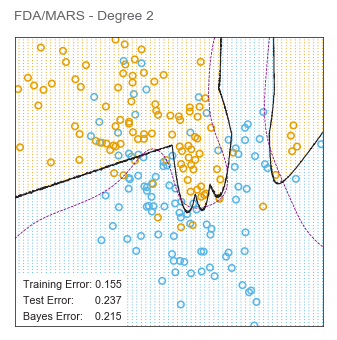

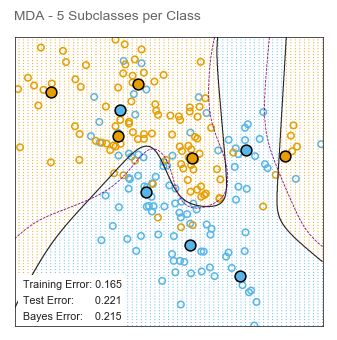

In [40]:
# PAGE 452. FIGURE 12.13. FDA and MDA on the mixture data. The upper plot uses
#           FDA with MARS as the regression procedure. The lower plot uses MDA
#           with five mixture centers per class (indicated). The MDA solution
#           is close to Bayes optimal, as might be expected given the data
#           arise from mixtures of Gaussians. The broken purple curve in the
#           background is the Bayes decision boundary
_, _ = plot_model_stat(fda.predict, 'FDA/MARS - Degree 2')
plot_prototypes_model(
    mda.predict, 'MDA - 5 Subclasses per Class',
    mda.means_[0], mda.means_[1])

## Prototypes and Nearest-Neighbors

In [41]:
from sklearn.cluster import KMeans

In [42]:
# PAGE 460. To use K-means clustering for classification of labeled data, the
#           steps are:
#           - apply K-means clustering to the training data in each class
#             separately, using R prototypes per class;
#           - assign a class label to each of the K x R prototypes;
#           - classify a new feature x to the class of the closest prototype.
kmeans_blue = KMeans(n_clusters=5).fit(X_test[y_test == 0])
kmeans_orange = KMeans(n_clusters=5).fit(X_test[y_test == 1])

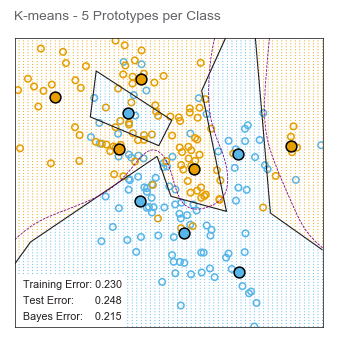

In [43]:
def k_means_predict(X):
    return np.argmin(np.vstack((np.min(kmeans_blue.transform(X), axis=1),
                                np.min(kmeans_orange.transform(X), axis=1))).T,
                     axis=1)


# PAGE 464. The upper panel shows the K-means classifier applied to the mixture
#           data example. The decision boundary is piecewise linear.
plot_prototypes_model(
    k_means_predict, 'K-means - 5 Prototypes per Class',
    kmeans_blue.cluster_centers_, kmeans_orange.cluster_centers_)

In [44]:
# PAGE 463. As a consequence, the Gaussian mixture model is ofthen referred to
#           as a soft clustering method, while K-means is hard.
gm_blue = GaussianMixture(
    n_components=5, covariance_type='spherical', random_state=3
).fit(X_test[y_test == 0])
gm_orange = GaussianMixture(
    n_components=5, covariance_type='spherical', random_state=3
).fit(X_test[y_test == 1])

In [45]:
def gaussian_mixture_predict(X):
    blue_rvs = [(gm_blue.weights_[i],
                 multivariate_normal(gm_blue.means_[i],
                                     gm_blue.covariances_[i]))
                for i in range(5)]
    orange_rvs = [(gm_orange.weights_[i],
                   multivariate_normal(gm_orange.means_[i],
                                       gm_orange.covariances_[i]))
                  for i in range(5)]
    p_blue = np.sum(
        np.array([rv[0] * rv[1].pdf(X) for rv in blue_rvs]), axis=0)
    p_orange = np.sum(
        np.array([rv[0] * rv[1].pdf(X) for rv in orange_rvs]), axis=0)
    y_hat = 1*(p_orange > p_blue)
    return y_hat    

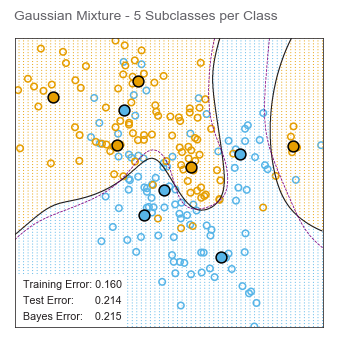

In [46]:
# PAGE 464. The lower panel shows a Gaussian mixture model with a common
#           covariance for all component Gaussians. The EM algorithm for the
#           mixture model was started at the K-means solution.
plot_prototypes_model(
    gaussian_mixture_predict, 'Gaussian Mixture - 5 Subclasses per Class',
    gm_blue.means_, gm_orange.means_)

## k-Nearest-Neighbor Classifiers

In [47]:
n_neighbors_vals = list(range(1, 30, 2))
k_neighbors_grid_search = GridSearchCV(
    KNeighborsClassifier(),
    {'n_neighbors': n_neighbors_vals},
    cv=10, scoring='accuracy',
    return_train_score=True, iid=True
).fit(X_train, y_train)

train_errors, test_errors = [], []
for k in n_neighbors_vals:
    clf = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    train_errors.append(1 - clf.score(X_train, y_train))
    test_errors.append(1 - clf.score(X_test, y_test))

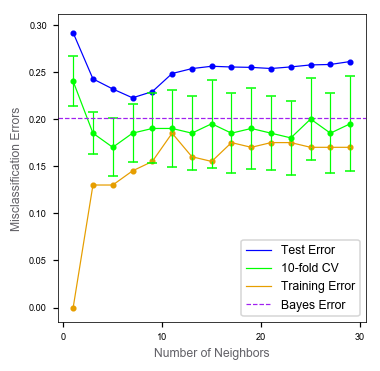

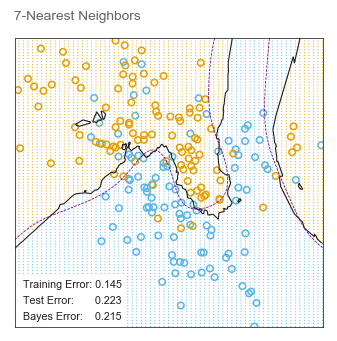

In [48]:
# PAGE 467. k-nearest-neighbors on the two-class mixture data. The upper
#           panel shows the misclassification errors as a function of
#           neighborhood size. Standard error bars are included for 10-fold
#           cross validation. The lower panel shows the decision boundary
#           for 7-nearest-neighbors, which appears to be optimal for minimizing
#           test error.
cv_erros = 1 - np.vstack([
    k_neighbors_grid_search.cv_results_[f'split{i}_test_score']
    for i in range(10)]).T
cv_mean_errors = np.mean(cv_erros, axis=1)
cv_std_errors = np.std(cv_erros, ddof=1, axis=1)/np.sqrt(10)
best_index = np.argmin(cv_mean_errors)
best_err, best_std_err = cv_mean_errors[best_index], cv_std_errors[best_index]

fig, ax = plt.subplots(figsize=(2.8, 2.8), dpi=110)
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax.scatter(n_neighbors_vals, test_errors, c='#0000FF', s=9)
ax.plot(n_neighbors_vals, test_errors, c='#0000FF', linewidth=0.8,
        label='Test Error')
ax.plot(n_neighbors_vals, cv_mean_errors, c='#00FF00', linewidth=0.8,
        label='10-fold CV')
ax.scatter(n_neighbors_vals, train_errors, c=ORANGE, s=9)
ax.plot(n_neighbors_vals, train_errors, c=ORANGE, linewidth=0.8,
        label='Training Error')

ax.errorbar(n_neighbors_vals, cv_mean_errors,
            color='#00FF00', linestyle='None', marker='o', elinewidth=0.8,
            markersize=3, yerr=cv_std_errors, ecolor='#00FF00', capsize=3)
ax.axhline(y=best_err+best_std_err, c=PURPLE, linewidth=0.8, linestyle='--',
           label='Bayes Error')
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(6)
ax.set_xlabel('Number of Neighbors', color=GRAY4, fontsize=8)
ax.set_ylabel('Misclassification Errors', color=GRAY4, fontsize=8)

neighbors7_classifier = KNeighborsClassifier(
    n_neighbors=7).fit(X_train, y_train)
plot_model_stat(neighbors7_classifier.predict, '7-Nearest Neighbors')
_ = ax.legend(loc='bottom right', prop={'size': 8})

## Random Forests

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import MDS

In [50]:
random_forest_classifier = RandomForestClassifier(
    n_estimators=35,
    random_state=0,
    oob_score=True
).fit(X_train, y_train)
neighbors3_classifier = KNeighborsClassifier(
    n_neighbors=3
).fit(X_train, y_train)

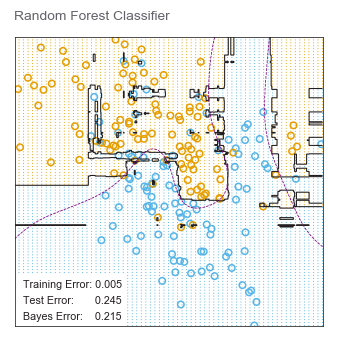

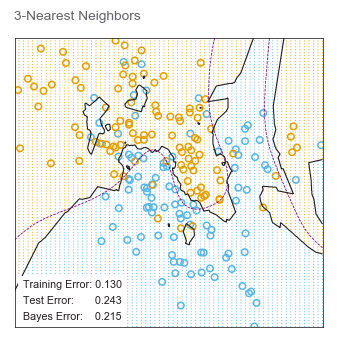

In [51]:
# PAGE 602. FIGURE 15.11 Random forests versus 3-NN on the mixture data. The
#           axis-oriented nature of the individual trees in a random forest
#           lead to decision regions with an axis-oriented flavor.
plot_model_stat(
    random_forest_classifier.predict, 'Random Forest Classifier')
_, _ = plot_model_stat(
    neighbors3_classifier.predict, '3-Nearest Neighbors')

In [52]:
# PAGE 595. In growing a random forest, an NxN proximity matrix is accumulated
#           for the training data. For every tree, any pair of OOB observations
#           sharing a terminal node has their proximity increased by one.
# my approach is slightly incorrect, because we should use
# out-of-bag observations only, but I don't know how to get it
leaf_ids = random_forest_classifier.apply(X_train)
N = X_train.shape[0]
proximity_matrix = np.zeros((N, N))
for i in range(leaf_ids.shape[1]):
    tree_leaf_ids = leaf_ids[:, i]
    proximity_matrix += np.equal.outer(tree_leaf_ids, tree_leaf_ids)
proximity_matrix /= leaf_ids.shape[1]

In [53]:
# PAGE 595. This proximity matrix is then represented in two dimensions using
#           multidimensional scaling (Secion 14.8). The idea is that even
#           though the data may be high-dimensional, involving mixed variables,
#           etc., the proximity plot gives and indication of which observations
#           are effectively close together in the eyes of the random forest
#           classifier.
mds = MDS(
    n_components=2,
    dissimilarity='precomputed',
    random_state=1
).fit_transform(1 - proximity_matrix)
centers = KMeans(n_clusters=6).fit(mds).cluster_centers_
closest_idx = [
    np.argmin(np.sum((mds - centers[i])**2, axis=1)) for i in range(6)]
mds_points = mds[closest_idx]
obs_points = X_train[closest_idx]

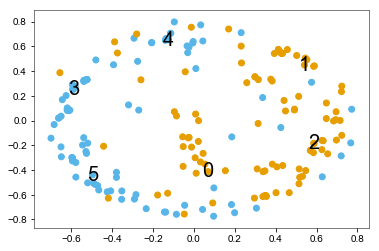

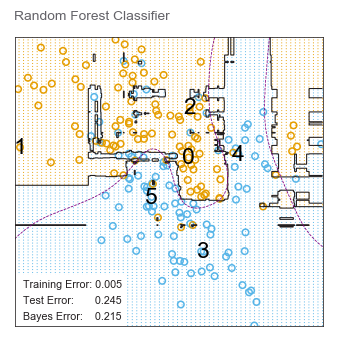

In [54]:
# PAGE 595. FIGURE 15.6. (Left): Proximity plot for a random forest classifier
#           grown to the mixture data. (Right): Decision boundary and training
#           data for random forest on mixture data. Six points have been
#           identified in each plot.
plt.scatter(mds[:, 0], mds[:, 1], c=np.array([BLUE, ORANGE])[y_train])
for i in range(6):
    plt.annotate(f'{i}', mds_points[i], ha='center', va='center',
                 color='black', fontsize=20)

fig, ax = plot_model_stat(
    random_forest_classifier.predict, 'Random Forest Classifier')
for i in range(6):
    ax.annotate(f'{i}', obs_points[i], ha='center', va='center',
                color='black', fontsize=15)